# Import library

In [1]:
import keras
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from random import randint

Using TensorFlow backend.


# Read orl_faces data

In [2]:
path = './dataset/orl_faces/'

IMAGE_SIZE = (32, 32)
# 1-hot encoding
a = np.array([i for i in range(43)])
classes = np.zeros((a.size, a.max() + 1))
classes[np.arange(a.size), a] = 1

train_array = []
test_array = []
dir_array = []

# let random index and 9th(enumerate begins at 0 so index 8 represents image 9) pgm for test
for dir in os.listdir(path):
    i1, i2 = 8, randint(0, 7)
    for idx, img in enumerate(sorted(os.listdir(path + dir))):
        image = cv2.imread(path + dir + '/' + img, 0)
        image = cv2.resize(image, IMAGE_SIZE)
        image = image[:, :, np.newaxis]
        if idx == i1 or idx == i2:
            test_array.append((image, classes[os.listdir(path).index(dir)]))
            continue

        train_array.append((image, classes[os.listdir(path).index(dir)]))
    dir_array.append(dir)

In [3]:
len(train_array), len(test_array), len(dir_array)

(344, 86, 43)

# Split train_images and test_images

In [4]:
train_images, train_labels = np.array([t[0] for t in train_array]), np.array([t[1] for t in train_array])
test_images, test_labels = np.array([t[0] for t in test_array]), np.array([t[1] for t in test_array])

# Plot some sample of train_images

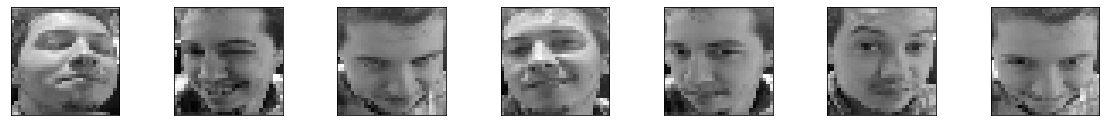

In [5]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(train_images[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Normalize train_images and test_images

In [6]:
x_train = train_images.astype('float32') / 255.
x_test = test_images.astype('float32') / 255.

# Add some noise 

In [7]:
noise_factor = 0.01
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Plot noisy images

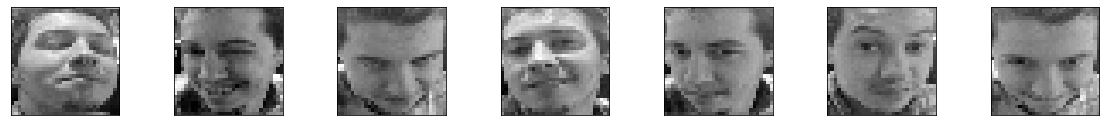

In [8]:
n = 7
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_noisy[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Reshape images for using deep autoencoder

In [9]:
x_train = x_train_noisy.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test_noisy.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(344, 1024)
(86, 1024)


# Deep autoencoder

In [15]:
encoding_dim = 128 

# This is our input image
input_img = keras.Input(shape=(1024,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(32, activation='sigmoid')(encoded)
decoded = layers.Dense(64, activation='sigmoid')(decoded)
decoded = layers.Dense(128, activation='sigmoid')(decoded)
decoded = layers.Dense(1024, activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320

In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 344 samples, validate on 86 samples
Epoch 1/50
344/344 [==============================] - 0s 933us/step - loss: 0.6782 - val_loss: 0.6624
Epoch 2/50
344/344 [==============================] - 0s 241us/step - loss: 0.6612 - val_loss: 0.6592
Epoch 3/50
344/344 [==============================] - 0s 244us/step - loss: 0.6596 - val_loss: 0.6585
Epoch 4/50
344/344 [==============================] - 0s 230us/step - loss: 0.6591 - val_loss: 0.6583
Epoch 5/50
344/344 [==============================] - 0s 247us/step - loss: 0.6590 - val_loss: 0.6582
Epoch 6/50
344/344 [==============================] - 0s 232us/step - loss: 0.6589 - val_loss: 0.6582
Epoch 7/50
344/344 [==============================] - 0s 238us/step - loss: 0.6589 - val_loss: 0.6580
Epoch 8/50
344/344 [==============================] - 0s 273us/step - loss: 0.6587 - val_loss: 0.6579
Epoch 9/50
344/344 [==============================] - 0s 250us/step - loss: 0.6585 - val_loss: 0.6576
Epoch 10/50
344/344 [================

<AxesSubplot:>

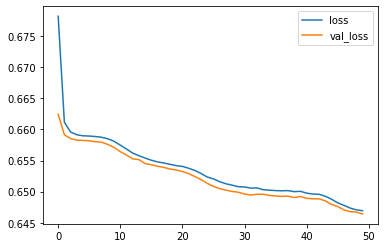

In [18]:
model_loss_history = pd.DataFrame({'loss': autoencoder.history.history['loss'],
                                   'val_loss': autoencoder.history.history['val_loss']})
model_loss_history.plot()

In [19]:
autoencoder.evaluate(x=x_test, y=x_test)

86/86 [==============================] - 0s 105us/step


0.6464088780935421

# Reshape images for face_recognition_model

In [20]:
x_train = np.reshape(x_train, (len(x_train), 32, 32, 1))
x_test = np.reshape(x_test, (len(x_test), 32, 32, 1))

# face_recognition_model

In [21]:
input_shape = (32, 32, 1)

face_recognition_model = Sequential()
#  BLOCK 1
# convolutional layer 16 windows/filters of 3x3
face_recognition_model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu',
                     kernel_regularizer=regularizers.l2(0.),
                     activity_regularizer=regularizers.l2(0.),
                     input_shape=input_shape))

# max of each 2x2 block
face_recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
# normalization
face_recognition_model.add(BatchNormalization())
# avoid overfitting
face_recognition_model.add(Dropout(0.25))

#  BLOCK 2
face_recognition_model.add(Conv2D(filters=32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_regularizer=regularizers.l2(0.),
                     activity_regularizer=regularizers.l2(0.)))

face_recognition_model.add(MaxPooling2D(pool_size=(2, 2)))
face_recognition_model.add(BatchNormalization())
face_recognition_model.add(Dropout(0.25))

# flatten for final layers
face_recognition_model.add(Flatten())

# fully-connected layer
face_recognition_model.add(Dense(3000, activation='relu',kernel_regularizer=regularizers.l2(0.),
                activity_regularizer=regularizers.l2(0.)))
face_recognition_model.add(Dropout(0.25))

face_recognition_model.add(Dense(units=43, activation='softmax'))

face_recognition_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 32)         

In [22]:
face_recognition_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
history = face_recognition_model.fit(train_images, train_labels,
                        batch_size=20,
                        epochs=12,
                        verbose=2,
                        validation_data=(test_images, test_labels))

Train on 344 samples, validate on 86 samples
Epoch 1/12
 - 2s - loss: 2.7881 - accuracy: 0.3779 - val_loss: 13.5101 - val_accuracy: 0.1279
Epoch 2/12
 - 1s - loss: 0.5079 - accuracy: 0.8634 - val_loss: 12.4030 - val_accuracy: 0.1279
Epoch 3/12
 - 1s - loss: 0.1094 - accuracy: 0.9709 - val_loss: 6.4085 - val_accuracy: 0.2674
Epoch 4/12
 - 1s - loss: 0.0427 - accuracy: 0.9913 - val_loss: 3.6598 - val_accuracy: 0.4302
Epoch 5/12
 - 1s - loss: 0.0397 - accuracy: 0.9855 - val_loss: 2.3135 - val_accuracy: 0.5465
Epoch 6/12
 - 1s - loss: 0.0147 - accuracy: 0.9971 - val_loss: 1.5501 - val_accuracy: 0.6163
Epoch 7/12
 - 1s - loss: 0.0263 - accuracy: 0.9884 - val_loss: 0.9611 - val_accuracy: 0.7674
Epoch 8/12
 - 1s - loss: 0.0184 - accuracy: 0.9971 - val_loss: 0.8180 - val_accuracy: 0.7791
Epoch 9/12
 - 1s - loss: 0.0253 - accuracy: 0.9942 - val_loss: 0.3991 - val_accuracy: 0.8837
Epoch 10/12
 - 1s - loss: 0.0304 - accuracy: 0.9913 - val_loss: 0.3658 - val_accuracy: 0.8721
Epoch 11/12
 - 1s - lo

<AxesSubplot:>

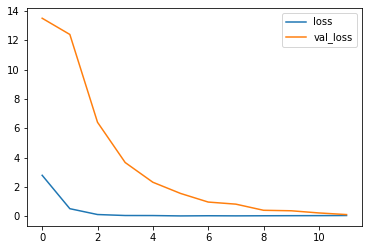

In [24]:
import pandas as pd
model_loss_history = pd.DataFrame({'loss': face_recognition_model.history.history['loss'],
                                   'val_loss': face_recognition_model.history.history['val_loss']})
model_loss_history.plot()

<AxesSubplot:>

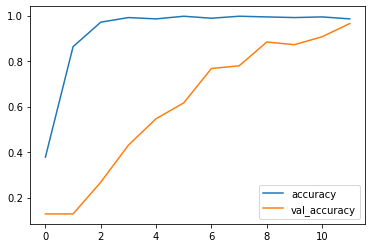

In [25]:
model_accuracy_history = pd.DataFrame({'accuracy': face_recognition_model.history.history['accuracy'],
                                       'val_accuracy': face_recognition_model.history.history['val_accuracy']})
model_accuracy_history.plot()

In [26]:
face_recognition_model.evaluate(x=test_images, y=test_labels)

86/86 [==============================] - 0s 465us/step


[0.10618072574914889, 0.9651162624359131]

# Save model

In [28]:
face_recognition_model.save('deep_model.h5')  # creates a HDF5 file 'deep_model.h5'

# Evaluate model

In [35]:
def evaluate_model(test_images, test_labels, classes, dir_array):
    # returns a compiled model
    # identical to the previous one
    model = load_model('deep_model.h5')

    score = model.evaluate(test_images, test_labels, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # evaluate test images added in the orl database
    imageindex = 9

    pathsorin1 = './dataset/orl_faces/sorin/' + str(imageindex) + '.pgm'
    sorin1 = cv2.imread(pathsorin1, cv2.IMREAD_UNCHANGED)
    #cv2.imshow("imageofsorin", sorin1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    sorin1 = cv2.resize(sorin1, (32, 32))
    sorin1 = sorin1[:, :, np.newaxis]

    
    imageindex = 9

    pathandreea1 = './dataset/orl_faces/andreea/' + str(imageindex) + '.pgm'
    andreea1 = cv2.imread(pathandreea1, cv2.IMREAD_UNCHANGED)
    #cv2.imshow("imageofandreea", andreea1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    andreea1 = cv2.resize(andreea1, (32, 32))
    andreea1 = andreea1[:, :, np.newaxis]

    imageindex = 9

    pathalex1 = './dataset/orl_faces/alex/' + str(imageindex) + '.pgm'
    alex1 = cv2.imread(pathalex1, cv2.IMREAD_UNCHANGED)
    #cv2.imshow("imageofalex", alex1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    alex1 = cv2.resize(alex1, (32, 32))
    alex1 = alex1[:, :, np.newaxis]

    people_test_image = np.array([sorin1, andreea1, alex1])
    [prediction1, prediction2, prediction3] = model.predict(people_test_image)

    a = max([(c, cosine_similarity([prediction1], [c])) for c in classes], key=lambda t:t[1])
    b = max([(c, cosine_similarity([prediction2], [c])) for c in classes], key=lambda t:t[1])
    c = max([(c, cosine_similarity([prediction3], [c])) for c in classes], key=lambda t:t[1])

    print(dir_array[list(a[0]).index(1)])
    print(dir_array[list(b[0]).index(1)])
    print(dir_array[list(c[0]).index(1)])

In [36]:
evaluate_model(test_images, test_labels, classes, dir_array)

Test loss: 0.10618072574914889
Test accuracy: 0.9651162624359131


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\imgproc\src\resize.cpp:3929: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'
